In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/sample.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv


In [2]:
np.random.seed(42)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import html
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score,GridSearchCV, KFold, StratifiedKFold,cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2,mutual_info_classif
from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.decomposition import PCA, TruncatedSVD
#from word_cloud import Word_cloud

# Data Loading

In [4]:
df = pd.read_csv('/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv')
testdf = pd.read_csv('/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv')

# Exploratory Data Analysis

In [5]:
df.head()

,ID,RecipeNumber,RecipeCode,RecipeName,CommentID,UserID,UserName,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,BestScore,Recipe_Review
0,70,71,12259,Banana Bars with Cream Cheese Frosting,sp_aUSaElGf_12259_c_149978,u_1oKVaBmiEKwAFyiHrDLoWpbel0J,misscoffeepot,20,1622717078,0,0,0,5,100,great recipe! I have made them just as written...
1,72,88,8202,Simple Taco Soup,sp_aUSaElGf_8202_c_310332,u_1oKZeRIXYzGNhGW8OMR3O4lX1ih,MichelleMalone,1,1622717852,0,0,1,5,100,This is an easy and quick recipe that is great...
2,458,3,2832,Cheeseburger Soup,sp_aUSaElGf_2832_c_206522,u_1oKYHUtdaD48KJCDYq5wfpAUxWz,jeannem32,1,1622717357,0,0,0,3,100,I think I was looking for something extra spec...
3,7,50,100276,Grilled Huli Huli Chicken,sp_aUSaElGf_100276_c_434088,u_1oKZCQcKQZdQhDVBS7oISc216VA,ds422,1,1622648899,0,0,0,5,100,This is our favorite grilled chicken recipe. ...
4,60,12,19731,Cauliflower Soup,sp_aUSaElGf_19731_c_387011,u_1oKd4sudZQPgu6YALiC7bW7mKMs,SusanHoward,1,1622718260,0,0,0,4,100,Great basic recipe. I added 2 teaspoons Tuscan...


In [6]:
df.info() # there are 2 null values in Recipe_Review colulmn

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13636 entries, 0 to 13635
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 13636 non-null  int64 
 1   RecipeNumber       13636 non-null  int64 
 2   RecipeCode         13636 non-null  int64 
 3   RecipeName         13636 non-null  object
 4   CommentID          13636 non-null  object
 5   UserID             13636 non-null  object
 6   UserName           13636 non-null  object
 7   UserReputation     13636 non-null  int64 
 8   CreationTimestamp  13636 non-null  int64 
 9   ReplyCount         13636 non-null  int64 
 10  ThumbsUpCount      13636 non-null  int64 
 11  ThumbsDownCount    13636 non-null  int64 
 12  Rating             13636 non-null  int64 
 13  BestScore          13636 non-null  int64 
 14  Recipe_Review      13634 non-null  object
dtypes: int64(10), object(5)
memory usage: 1.6+ MB


In [7]:
df.describe()

,ID,RecipeNumber,RecipeCode,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,BestScore
count,13636.000000,13636.000000,13636.000000,13636.000000,1.363600e+04,13636.000000,13636.000000,13636.000000,13636.000000,13636.000000
mean,121.085289,38.624377,21785.990833,2.160311,1.623713e+09,0.014520,1.098269,0.543708,4.288721,153.127897
std,116.995633,29.672351,23883.189918,10.086424,5.444020e+06,0.137323,4.166487,3.265660,1.544839,140.986908
min,0.000000,1.000000,386.000000,0.000000,1.613035e+09,0.000000,0.000000,0.000000,0.000000,0.000000
25%,45.000000,12.000000,6504.000000,1.000000,1.622717e+09,0.000000,0.000000,0.000000,5.000000,100.000000
50%,91.000000,33.000000,14600.000000,1.000000,1.622718e+09,0.000000,0.000000,0.000000,5.000000,100.000000
75%,148.000000,63.000000,33121.000000,1.000000,1.622718e+09,0.000000,0.000000,0.000000,5.000000,100.000000
max,724.000000,100.000000,191775.000000,510.000000,1.665756e+09,3.000000,80.000000,126.000000,5.000000,946.000000


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Rating', ylabel='Count'>

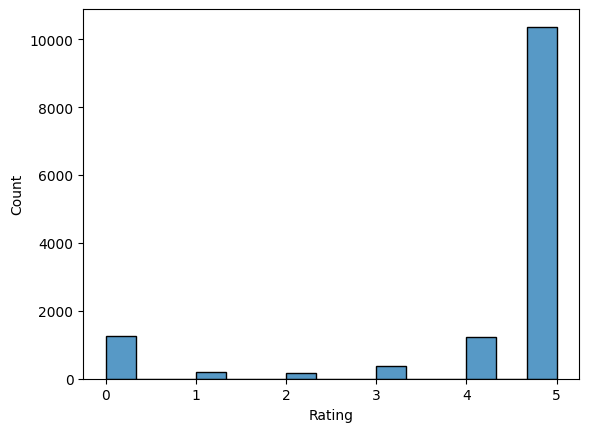

In [8]:
sns.histplot(df['Rating'])

In [9]:
plt.figure(figsize=(10,10))
sns.heatmap(df[num].corr(),annot=True)

NameError: name 'num' is not defined

<Figure size 1000x1000 with 0 Axes>

In [ ]:
sns.pairplot(df[['RecipeNumber','UserReputation','ReplyCount','ThumbsUpCount','ThumbsDownCount','BestScore']])

In [ ]:
df['RecipeNumber'].value_counts() #distrubution of no of reviews based on ranking of the Recipe
plt.figure(figsize=(20,10))
sns.countplot(x=df['RecipeNumber']) # We observer that the top recipies in ranking have large number of reviews and as the rank goes down the reviews also become less

In [ ]:
df.value_counts('UserID') #max no of reviews by singele user is 20
df.value_counts('UserReputation') #few useres have very high reputation most useres have 1 reputation, There are 118 reviews with 0 user rep.
df[df['UserReputation'] == 0]['Rating'].value_counts() #total users with 0 rep = 111

In [ ]:
def date_transform(df):
    df['Date'] = df['CreationTimestamp'].apply(lambda x: pd.Timestamp(x,unit='s'))
    df['day'] = df['Date'].apply(lambda x : x.day)
    df['month'] = df['Date'].apply(lambda x : x.month)
    df['year'] = df['Date'].apply(lambda x : x.year)
    df['time'] = df['Date'].apply(lambda x : x.time().hour)
    df['dow'] = df['Date'].apply(lambda x : x.weekday())
    return df
df = date_transform(df)

In [ ]:
df.sort_values('Date')['Date'] #Data is from 2021-02-11 09:22:16 to 2022-10-14 14:00:35

In [ ]:
df.groupby('time').count()['Rating'] # most reviwes are posted between 10 to 11am everyday
df.groupby('day').count()['Rating']  # most reviwes are posted on 3rd every month
df.groupby('month').count()['Rating'] # most reviwes are posted in June
#df.groupby('yeay').count()['Rating'] # most reviwes are posted in 2021

In [ ]:
df[(df['year'] == 2021)&(df['month'] == 6) & (df['day'] == 3) & ((df['time'] == 10) | (df['time'] ==11))]['Rating'].count() ##More than 12,000 reviews were posted on 3rd June 2021 between 10 am and 12pm

In [ ]:
plt.figure(figsize =(15,6))
sns.histplot(x = 'dow',data=df,hue='Rating',multiple='dodge')
plt.xticks([0,1,2,3,4,5,6],labels=['Monday','Tuesday','Wednesday','Thusday','Friday','Saturday','Sunday'])
plt.xlabel('Day Of Week')
plt.ylabel('Count of Reviews')
plt.title('No of reviews based on day of week')
plt.show()

**Insight** : Most reviews have timestamp of 3rd June 2021 which was Thusday. The distrbution of ratings is skewded towards 5 regardless of Day of Week

In [ ]:
#text = html.unescap
#svc
#decision tree
#lgbm 

# Feature Selection

In [ ]:
num = ['ID','RecipeNumber','RecipeCode','UserReputation','CreationTimestamp','ReplyCount','ThumbsUpCount','ThumbsDownCount','BestScore','day','month','time','dow']
cat = ['CommentID','RecipeName','UserName']

**For Numerical Data**

In [ ]:
X = df[num]
Y = df['Rating']

kbest = SelectKBest(score_func=chi2, k=6)
X_best = kbest.fit_transform(X, Y)
print(kbest.get_support())
# Summarize scores
np.set_printoptions(precision=3)
print(fit.scores_)


# Data Cleaning

**Null Value Treatement**

In [ ]:
df.isnull().sum()

In [ ]:
df.dropna(inplace=True,axis=0)

In [ ]:

ratings = df[['RecipeCode','RecipeNumber','RecipeName','Recipe_Review','BestScore','Rating','UserReputation','ReplyCount','ThumbsUpCount', 'ThumbsDownCount','day','time']]

In [ ]:
def clean(x):
    x = html.unescape(x)
    x = x.lower()
    words = ''.join([i for i in x if i not in '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~1234567890'])
    return ' '.join([words])
ratings['Cleaned'] = ratings['Recipe_Review'].apply(lambda x: clean(str(x)))

In [ ]:
ratings.drop('Recipe_Review',axis=1,inplace=True)
ratings['len'] = ratings['Cleaned'].apply(lambda x: len(x))
sns.boxplot(ratings['len'])

In [ ]:
iqr = ratings['len'].quantile(.75) - ratings['len'].quantile(.25)
ul = ratings['len'].mean()+ 1.5*iqr
ratings1 = ratings[ratings['len']<ul]

In [ ]:
pd.options.display.max_colwidth = 500
x = ratings1.drop('Rating',axis=1)
y = ratings1['Rating']
x_tot,x_test,y_tot,y_test = train_test_split(x,y,test_size = 0.2,random_state=42,stratify=y)
x_train,xval,y_train,yval = train_test_split(x_tot,y_tot)

# Transformations and Pipelines

In [ ]:
numfeature = ['RecipeNumber','BestScore','UserReputation','ThumbsUpCount', 'ThumbsDownCount','day','time','ReplyCount']
cat = ['RecipeCode']
colt = ColumnTransformer([('minmax',MinMaxScaler(),numfeature),('ohe',OneHotEncoder(),cat),('tfidf',TfidfVectorizer(max_features=2500,ngram_range=(1,3),stop_words='english'),'Cleaned'),('tfidf2',TfidfVectorizer(),'RecipeName')])

#pipe = Pipeline([('trans',colt),('xgb',XGBClassifier())])

#pipe.fit(x_train,y_train)

# Model Building

In [ ]:
Kfold = StratifiedKFold(n_splits=3,shuffle=True,random_state=42)

In [ ]:
pipe1a = Pipeline([('trans',colt),('xgb',XGBClassifier(random_state=42))])
pipe1a.fit(x_train,y_train)
score1 = pipe1a.score(x_test,y_test)

In [ ]:
pipe2a = Pipeline([('trans',colt),('lr',LogisticRegression(max_iter=1000))])
pipe2a.fit(x_train,y_train)
score2 = pipe2a.score(x_test,y_test)

In [ ]:
pipe3 = Pipeline([('trans',colt),('rfc',RandomForestClassifier())])
pipe3.fit(x_train,y_train)
score3 = pipe3.score(x_test,y_test)

In [ ]:
pipe4 = Pipeline([('trans',colt),('LGB',(LGBMClassifier(random_state=42)))])
pipe4.fit(x_train,y_train)
score4 = pipe4.score(x_test,y_test)

In [ ]:
pipe4.fit(x,y)

In [ ]:
pipe1b = Pipeline([('trans',colt),('pca',TruncatedSVD(n_components=200,random_state=42)),('xgb',XGBClassifier(random_state=42))])
pipe1b.fit(x_train,y_train)
pipe1b.score(x_test,y_test)

In [ ]:
# pipe2a = Pipeline([('trans',colt),('pca',TruncatedSVD(random_state=42,n_components=200)),('lr',LogisticRegression(max_iter=1000))])
# pipe2a.fit(x_train,y_train)
# pipe2a.score(x_test,y_test)

In [ ]:
# pipe3b = Pipeline([('trans',colt),('pca',TruncatedSVD(random_state=42,n_components=200)),('rfc',RandomForestClassifier(random_state=42))])
# pipe3b.fit(x_train,y_train)
# pipe3b.score(x_test,y_test)

# **HyperParameter Tuning - Model 1**

In [ ]:
Kfold = StratifiedKFold(n_splits=3,shuffle=True,random_state=42)

In [ ]:
# params1a = {'xgb__objective' :['binary:logistic','multi: softmax'],'xgb__eta':[0.1],'xgb__max_depth':[6,7,8],'xgb__alpha' : [1,5],'xgb__subsample':[i/10.0 for i in range(6,10,2)],'xgb__eval_metric':['merror','mlogloss'],'xgb__n_estimators':[10,100,300]}
# #  'xgb__colsample_bytree':[i/10.0 for i in range(6,10)]}
# gs1a = GridSearchCV(pipe1a,param_grid=params1a,scoring='accuracy',verbose=4,cv=Kfold)
# gs1a.fit(x,y)

In [ ]:
gs1a.best_params_

In [ ]:
gs1a

{'xgb__alpha': 1,
 'xgb__eta': 0.1,
 'xgb__eval_metric': 'merror',
 'xgb__max_depth': 7,
 'xgb__n_estimators': 300,
 'xgb__objective': 'binary:logistic',
 'xgb__subsample': 0.8} : 
 params1a = {'xgb__objective' :['binary:logistic','multi: softmax'],'xgb__eta':[0.1],'xgb__max_depth':[6,7,8],'xgb__alpha' : [1,5],'xgb__subsample':[i/10.0 for i in range(6,10,2)],'xgb__eval_metric':['merror','mlogloss'],'xgb__n_estimators':[10,100,300]}
gs1a = GridSearchCV(pipe1a,param_grid=params1a,scoring='accuracy',verbose=4,cv=Kfold)
gs1a.fit(x,y)

In [ ]:
xgb_best = Pipeline([('trans',colt),('xgb',XGBClassifier(random_state=42,alpha = 1,eta = 0.1,eval_metric = 'merror',max_depth = 7,n_estimators = 300,objectibe = 'binary:logistic',subsample =0.8))])
xgb_best.fit(x_train,y_train)
score1 = xgb_best.score(x_test,y_test)

In [ ]:
confusion_matrix(y_test,gs1a.predict(x_test))

In [ ]:
pd.Series(gs1a.predict(x)).value_counts()

{'xgb__class_weight': 'None',
 'xgb__eta': 0.1,
 'xgb__gamma': 0.1,
 'xgb__max_depth': 9,
 'xgb__num_class': 6,
 'xgb__objective': 'binary:logistic',
 'xgb__scale_pos_weight': 1}

# Hyperparameter Tuning - Model 2

In [ ]:
# Kfold = StratifiedKFold(n_splits=3,shuffle=True,random_state=42)
# params3a = {'rfc__n_estimators' :[5,10,20,40,70,100,150],'rfc__max_features':[0.6,0.7,0.8,0.9,1],'rfc__min_samples_split':[2,4,6],'rfc__max_depth':[5,6,7,8]}
# gs3a = GridSearchCV(pipe3,param_grid=params3a,scoring='accuracy',verbose=4,cv=Kfold)
# gs3a.fit(x_train,y_train)

In [ ]:
gs3a.best_params_

{'rfc__max_depth': 8,
 'rfc__max_features': 0.8,
 'rfc__min_samples_split': 4,
 'rfc__n_estimators': 10}

In [ ]:
rfc_best = Pipeline([('trans',colt),('rfc',RandomForestClassifier(random_state=42,min_samples_split = 4,max_features = 0.8,max_depth = 8,n_estimators = 10))])
rfc_best.fit(x_train,y_train)
score3 = rfc_best.score(x_test,y_test)

In [ ]:
rfc_best = Pipeline([('trans',colt),('rfc',RandomForestClassifier(random_state=42,min_samples_split = 4,max_features = 0.8,max_depth = 8,n_estimators = 10))])
rfc_best.fit(x,y)
score3 = rfc_best.score(x_test,y_test)

In [ ]:
score3

In [ ]:
gs3a.best_estimator_.score(x_test,y_test)

In [ ]:
gs3a.best_params_

In [ ]:
gs3a.best_estimator_.score(x_train,y_train)

In [ ]:
rfc_best = gs3a.best_estimator_

In [ ]:
rfc_best.fit(x,y)

In [ ]:
Kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
tr =[]
val =[]
params3 = {'rfc__max_depth': [100],'rfc__min_samples_split':[2],'rfc__max_leaf_nodes':[160],'rfc__min_samples_leaf':[1],'rfc__n_estimators':[150],'rfc__max_features':[200]}
gs3 = GridSearchCV(pipe3,param_grid=params3,cv=Kfold,scoring='accuracy',verbose=4)
gs3.fit(x_train,y_train)
score3 = gs3.score(x_test,y_test)

# HyperParameter tuning Model 3 - LGBM model

In [ ]:
# cv = StratifiedKFold(n_splits = 5,random_state=42,shuffle=True)
# params = {'LGB__num_leaves':[10,20,30,40,50,60,70],'LGB__max_depth':[3,4,5,6,7,8],'LGB__n_estimators' :[10,20,30,40,50,60,70,80]}
# gs = GridSearchCV(pipe4,param_grid=params,cv=cv,scoring='accuracy',verbose=5,return_train_score=True)
#info = gs.fit(x_test,y_test)
# gs.best_params_
# lgb1 = gs.best_estimator_
# lgb1.fit(x_train,y_train)
# lgb1.score(x_test,y_test)
# val = cross_validate(lgb1,x_test,y_test,cv = KFold(n_splits=10,shuffle=True,random_state=42),scoring='accuracy')
# val['test_score'].mean()

In [ ]:
lgb_tuned = LGBMClassifier(random_state=42,verbose = -1,max_depth= 8, n_estimators=30, num_leaves=10)
pipe4_tuned.fit(x_train,y_train)
score4= pipe4_tuned.score(x_test,y_test)

# Model Evaluation

In [ ]:
score = [score1,score2,score3,score4]
models =['XGBClassifier','LogisticReg','RandomForestClassifier','LGB']
sns.scatterplot(x = models,y=score)

In [ ]:
model = XGBClassifier(objective ='binary:logistic',num_class= 6,class_weight= 'None',eta =0.1,max_depth=7,min_child_weight =3,gamma =0.3,scale_pos_weight =1,subsample =0.8,
 colsample_bytree=0.6)
pipe = Pipeline([('trans',colt),('xgb',model)])
pipe.fit(x,y)

# Testing

In [ ]:
testdf = pd.read_csv('/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv')
testdf['Date'] = testdf['CreationTimestamp'].apply(lambda x: pd.Timestamp(x,unit='s'))
testdf['day'] = testdf['Date'].apply(lambda x : x.day)
testdf['month'] = testdf['Date'].apply(lambda x : x.month)
testdf['yeay'] = testdf['Date'].apply(lambda x : x.year)
testdf['time'] = testdf['Date'].apply(lambda x : x.time().hour)
testdf['dow'] = testdf['Date'].apply(lambda x : x.weekday())
testdf['Cleaned'] = testdf['Recipe_Review'].apply(lambda x: clean(str(x)))
testdf.drop('Recipe_Review',axis=1,inplace=True)
pred = pipe4.predict(testdf)
pd.DataFrame(pred)
f = pd.DataFrame({'ID': np.arange(1,4547),'Rating' : pred})
f.to_csv('/kaggle/working/submission.csv',index=False)

In [ ]:
f['Rating'].value_counts()

In [ ]:
Rating
5    4418
0      90
3      25
4       8
1       4
2       1